# Basic CNN in Keras

* Keras Cheat Sheet: https://s3.amazonaws.com/assets.datacamp.com/blog_assets/Keras_Cheat_Sheet_Python.pdf

# Setup: Load modules

In [1]:
#import os; os.chdir("/notebooks/test_scripts")

# System 
import os
import sys 
import shutil
from time import time

# Simple CNN model for CIFAR-10
import numpy as np

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras.models import model_from_json

from keras import backend as K

# Datasets
from keras.datasets import cifar10
from keras.callbacks import ModelCheckpoint

# Images 
import matplotlib.pyplot as plt
from PIL import Image
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG

# Debugging 
import resource
import pprint
from keras.callbacks import TensorBoard
from keras_tqdm import TQDMNotebookCallback
from tensorflow.python import debug as tf_debug

# Stats
import pandas as pd

Using TensorFlow backend.


## GPU Setup

https://stackoverflow.com/questions/34199233/how-to-prevent-tensorflow-from-allocating-the-totality-of-a-gpu-memory

In [3]:
import tensorflow as tf
import keras.backend.tensorflow_backend as ktf

def get_session(gpu_fraction=0.1):
    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=gpu_fraction, allow_growth=True)
    return tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

ktf.set_session(get_session())

# Parameters: General

In [6]:
# For pprint 
pp = pprint.PrettyPrinter(indent=2)

# Set image dimension ordering
# NOTE: "tf" assumes (rows, cols, channels); "th" assumes (channels, rows, cols)
K.set_image_dim_ordering('tf')

# Initialize TensorBoard
# NOTE: write_graph makes file very large
tensorboard = TensorBoard(log_dir="/notebooks/tf_logs/{}".format(time()), histogram_freq=1, write_graph=False, write_images=True)

# Fix random seed
seed = 1
np.random.seed(seed)

# Data: Load data

In [7]:
# Data file 
cifar10_file = 'cifar10.npz'

# Save to file
# NOTE: Data loaded through pickle caused issues  
if not os.path.isfile(cifar10_file):
    # Downloaded from: http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()
    
    np.savez(cifar10_file, x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test)
else: 
    npz = np.load(cifar10_file)
    (x_train, y_train), (x_test, y_test) = ((npz['x_train'], npz['y_train']), (npz['x_test'], npz['y_test']))
        
num_train, img_channels, img_rows, img_cols = x_train.shape
num_test, _, _, _ =  x_train.shape
num_classes = len(np.unique(y_train))

# Data: Visualize training data

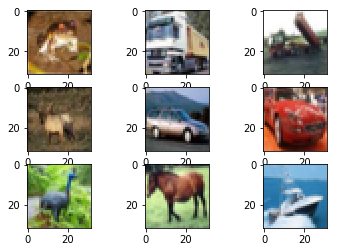

In [8]:
# Create a grid of 3x3 images
for i in range(0, 9):
    plt.subplot(330 + 1 + i)
    plt.imshow(Image.fromarray(x_train[i], 'RGB'))
    
# Show the plot
plt.show()

# Data: Normalize

In [9]:
# Data file 
cifar10_normalized_file = 'cifar10_normalized.npz'

# Save to file
if not os.path.isfile(cifar10_normalized_file):
    # Normalize inputs from 0-255 to 0.0-1.0
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    x_train = x_train / 255.0
    x_test = x_test / 255.0

    np.savez(cifar10_normalized_file, x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test)
else: 
    npz = np.load(cifar10_normalized_file)
    (x_train, y_train), (x_test, y_test) = ((npz['x_train'], npz['y_train']), (npz['x_test'], npz['y_test']))

# Data: One-hot Encode outputs

In [10]:
# One hot encode outputs
y_train = np_utils.to_categorical(y_train, num_classes)
y_test = np_utils.to_categorical(y_test, num_classes)
num_classes = y_test.shape[1]

# Parameters: Model

In [11]:
img_rows, img_cols = 32, 32
input_shape = (img_rows, img_cols, 3)
kernel_size = (3, 3)
pool_size = (2, 2)

# Model: Check shapes

In [12]:
assert x_train.shape[1:4]==input_shape, "ERROR: Shape"

# Model: Create

https://machinelearningmastery.com/object-recognition-convolutional-neural-networks-keras-deep-learning-library/

In [13]:
model = Sequential()
model.add(Conv2D(32, kernel_size=kernel_size, name='conv2d_1', input_shape=input_shape, padding='same', activation='relu', kernel_constraint=maxnorm(3)))
model.add(Dropout(0.2, name='dropout_1'))
model.add(Conv2D(32, kernel_size=kernel_size, name='conv2d_2', activation='relu', padding='same', kernel_constraint=maxnorm(3)))
model.add(MaxPooling2D(pool_size=pool_size, name='max_pooling2d_1'))
model.add(Flatten(name='flatten_1'))
model.add(Dense(512, name='dense_1', activation='relu', kernel_constraint=maxnorm(3)))
model.add(Dropout(0.5, name='dropout_2'))
model.add(Dense(num_classes, name='dense_2', activation='softmax'))

# Model: Summary

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               4194816   
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
__________

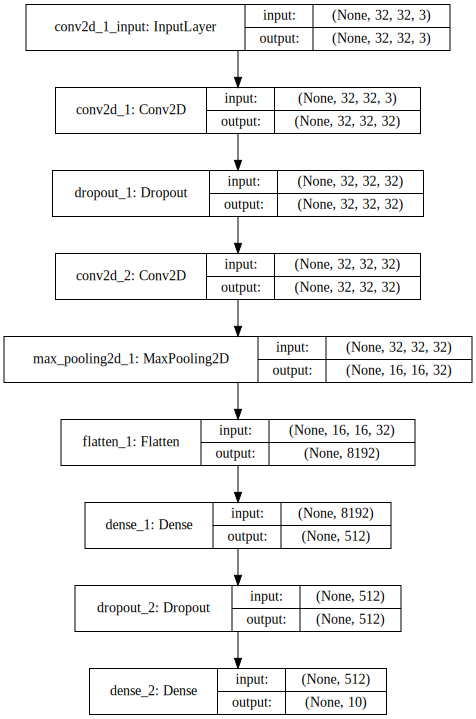

In [14]:
print(model.summary())
SVG(model_to_dot(model, show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))

# Parameters: Fit/Optimization

In [15]:
epochs = 10
batch_size = 64
lrate = 0.01
decay = lrate/epochs

# Model: Optimization

In [16]:
sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)

# Model: Checkpoints

In [17]:
if not os.path.isdir("./output"):
    os.makedirs("./output")

#filepath = "./output/weights_improvement_{epoch:02d}_{val_acc:.2f}.hdf5"
#checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

filepath = "./output/weights_best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

# Model: Load weights

Load any existing weights; to be done before compiling

In [15]:
# Save to file
checkpoint_file = "./output/weights.best.hdf5"

if os.path.isfile(checkpoint_file):
    model.load_weights(checkpoint_file)

# Model: Compile

In [16]:
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

# Model: Fit

Plotting history: https://www.learnopencv.com/image-classification-using-feedforward-neural-network-in-keras/

In [17]:
# NOTE: TQDMNotebookCallback() has issues: https://github.com/tqdm/tqdm/issues/451
# NOTE: One output per epoch, verbose=2
history = model.fit(x_train, y_train, 
            validation_data=(x_test, y_test), 
            epochs=epochs, 
            batch_size=batch_size, 
            verbose=2, 
            callbacks=[tensorboard, checkpoint])

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
Epoch 00000: val_acc improved from -inf to 0.47870, saving model to ./output/weights_best.hdf5
618s - loss: 1.7432 - acc: 0.3685 - val_loss: 1.4638 - val_acc: 0.4787
Epoch 2/10
Epoch 00001: val_acc improved from 0.47870 to 0.52410, saving model to ./output/weights_best.hdf5
561s - loss: 1.4266 - acc: 0.4848 - val_loss: 1.3257 - val_acc: 0.5241
Epoch 3/10
Epoch 00002: val_acc improved from 0.52410 to 0.57310, saving model to ./output/weights_best.hdf5
570s - loss: 1.2971 - acc: 0.5358 - val_loss: 1.2043 - val_acc: 0.5731
Epoch 4/10
Epoch 00003: val_acc improved from 0.57310 to 0.58970, saving model to ./output/weights_best.hdf5
616s - loss: 1.2030 - acc: 0.5705 - val_loss: 1.1709 - val_acc: 0.5897
Epoch 5/10
Epoch 00004: val_acc improved from 0.58970 to 0.60650, saving model to ./output/weights_best.hdf5
614s - loss: 1.1327 - acc: 0.5958 - val_loss: 1.1082 - val_acc: 0.6065
Epoch 6/10
Epoch 00005: val_acc improved from 0.60650

# Model: Evaluate

In [ ]:
[test_loss, test_acc] = model.evaluate(x_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (test_acc*100))

# Predictions

In [97]:
# NOTE: Values before one-hot encoding
y_test_class = npz['y_test'] 
y_test_class = y_test_class.flatten() 

i = 41
image = x_test[i:(i+1)]
predictions = model.predict(image, batch_size=32)[0]

## Predictions: Show

In [98]:
predictions

array([ 0.01355575,  0.00396832,  0.12665936,  0.09042446,  0.18089522,
        0.04137293,  0.50615209,  0.02952692,  0.00439233,  0.0030526 ], dtype=float32)

## Predictions: Class from Position of maximum

In [100]:
predictions.argmax(axis=0)

6

In [101]:
y_test_class[i] # Actual class

6

## Predictions: Maximum value

In [56]:
np.amax(predictions)

0.50615209

## Predictions: Show query image

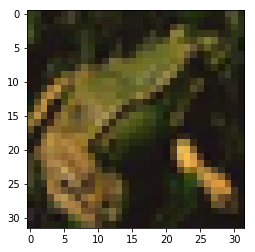

In [58]:
plt.imshow(image[0])
plt.show()

## Predictions: Get As Classes

In [91]:
max_entry = 4096
y_pred = model.predict_classes(x_test[0:max_entry], batch_size=1024)

4096/4096 [==============================] - 8s     


## Predictions: Predictions Over Many

In [92]:
pd.crosstab(y_pred, y_test_class[0:max_entry])

col_0,0,1,2,3,4,5,6,7,8,9
row_0,,,,,,,,,,
0,191,10,28,5,17,4,2,19,29,15
1,31,293,17,15,8,7,7,13,34,113
2,23,2,144,35,55,44,22,20,3,3
3,17,6,36,138,29,88,30,31,12,18
4,6,1,75,33,182,44,47,40,8,4
5,3,2,17,46,10,112,5,19,9,4
6,13,11,63,84,67,52,280,19,9,17
7,20,11,33,19,30,30,4,223,8,16
8,79,23,14,7,12,13,3,13,293,43


# Model: Serialize

https://machinelearningmastery.com/save-load-keras-deep-learning-models/

In [ ]:
if os.path.isdir("./output"):
    shutil.rmtree("./output")
os.makedirs("./output")

# Serialize model to JSON
model_json = model.to_json()
with open("output/model.json", "w") as json_file:
    json_file.write(model_json)
    
model.save_weights("output/model.h5")
print("Saved model")

# Model: Load

NOTE: Make sure optimizer 'sgd' is available from above

In [19]:
# Load json and create model
json_file = open('output/model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)

# Load weights into new model
model.load_weights("output/model.h5")
print("Loaded model")
 
# Evaluate loaded model on test data
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

[test_loss, test_acc] = model.evaluate(x_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (test_acc*100))

Loaded model
Accuracy: 50.05%


# Visualize: Layers; Feature (aka Activation) Maps 

Visualize activation maps also known as feature maps. 

In [25]:
from utils.visualize_activations import * 

%matplotlib inline
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (10,10)

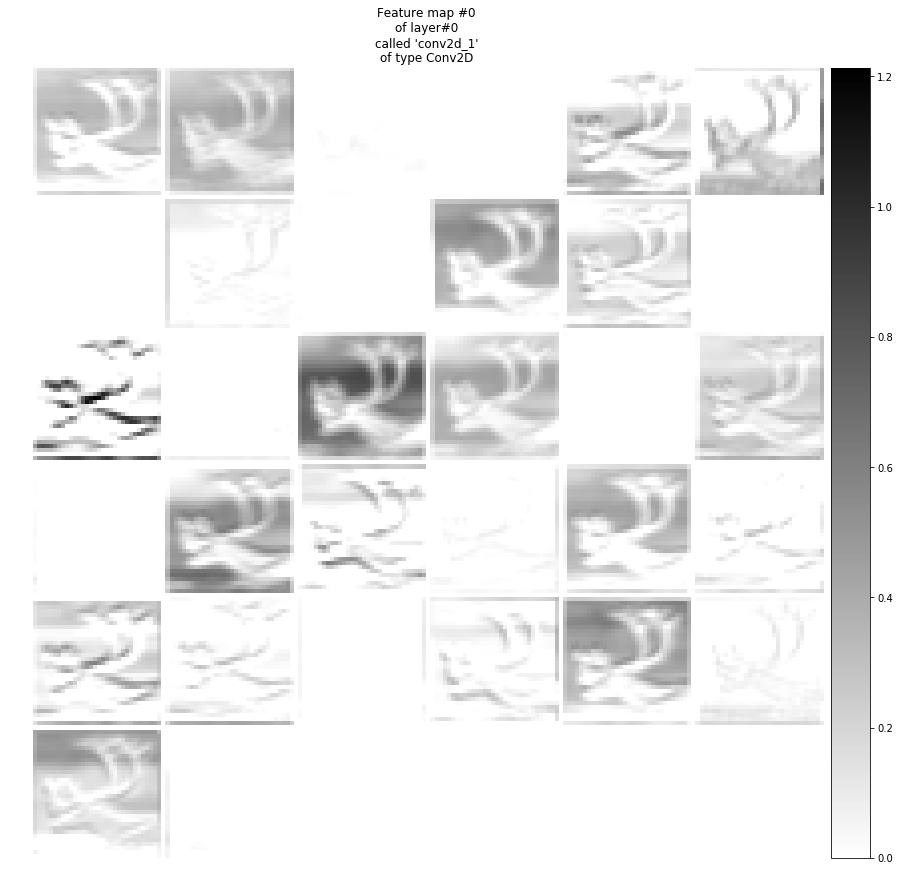

In [26]:
i = 40
image = x_test[i:(i+1)]
plot_feature_map(model, X=image, layer_id=0, n_columns=1, n=40)

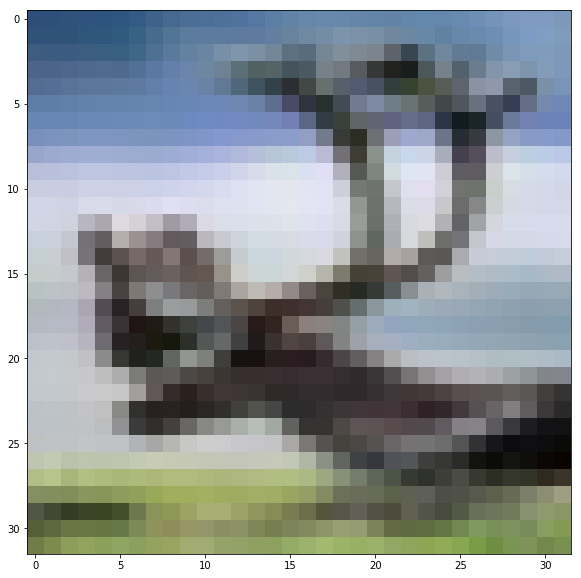

In [27]:
plt.imshow(image[0])

# Visualize: Saliency Map

In [28]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from utils.visualize_saliency import * 

## Compile Saliency Function For Given Layer

In [30]:
activation_layer = 'dense_2'
saliency = compile_saliency_function(model, activation_layer)

In [31]:
i = 1489
image = x_test[i:(i+1)]

tmp = saliency([image, 0])
tmp = tmp[0]
tmp = tmp[0]

tmp.shape

(32, 32, 3)

## Process Saliency Output

In [36]:
t1 = np.abs(tmp)
t2 = np.amax(t1, axis=2)

x = t2
xmax, xmin = x.max(), x.min()
x = (x - xmin)/(xmax - xmin)

normalized = x

## Original Image

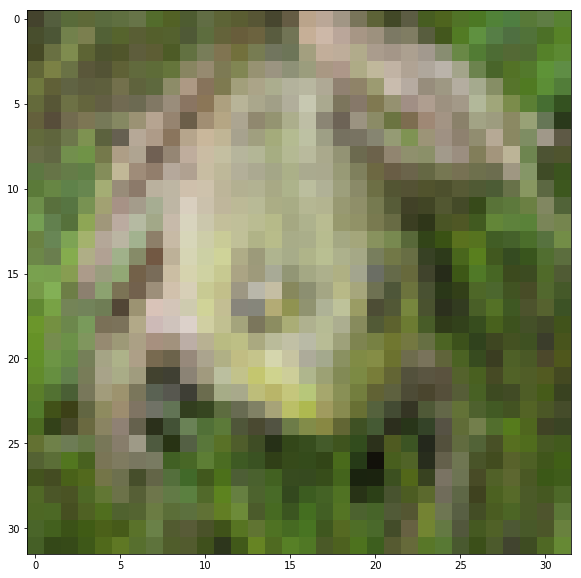

In [39]:
plt.imshow(image[0])
plt.show()

## Saliency Map

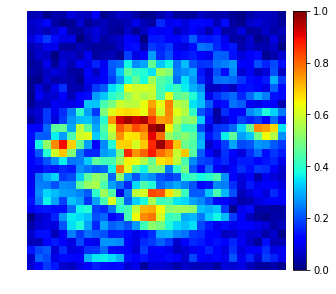

In [41]:
img = normalized

fig = plt.figure(figsize=(5, 5))

ax = fig.add_subplot(1, 1, 1)

im = ax.imshow(img, interpolation='none', cmap="jet")

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(im, cax=cax)

ax.axis('off')

plt.show()

## Combined Original And Saliency Map

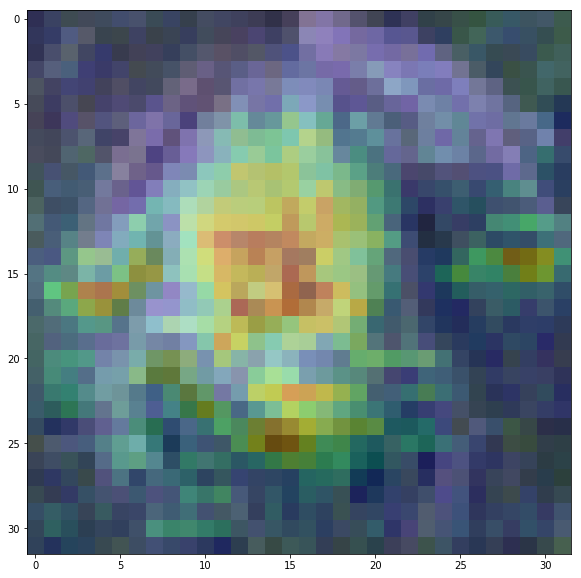

In [46]:
plt.figure(figsize=(10, 10))

im1 = plt.imshow(image[0], interpolation='none')
im2 = plt.imshow(img, cmap='jet', interpolation='none', alpha=0.3)

plt.show()

## Image Prediction Accuracy

In [49]:
# NOTE: Values before one-hot encoding
y_test_class = npz['y_test'] 
y_test_class = y_test_class.flatten()

y_salient = y_test_class[i:(i+1)]
img_salient = x_test[i:(i+1)]
predictions = model.predict(img_salient, batch_size=img_salient.shape[0])
predictions

array([[ 0.00640894,  0.00196373,  0.19140457,  0.04039608,  0.2418047 ,
         0.05304006,  0.43520945,  0.02531281,  0.00198797,  0.00247169]], dtype=float32)

In [50]:
max_output = np.take(predictions, y_salient)
max_output

array([ 0.43520945], dtype=float32)